In [16]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import csv
import random
import numpy as np

import time
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

from tensorflow.keras import backend as K

In [17]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Definição do diretório de saída
output_dir = "UNet++ DICE 5-fold model"
os.makedirs(output_dir, exist_ok=True)  # Garante que a pasta existe

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [18]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:19<00:00, 43.14it/s]


In [19]:
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    """Calcula o F1-Score para segmentação binária"""
    y_pred = K.round(y_pred)  # Arredondar para 0 ou 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'))  # Verdadeiros Positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))  # Falsos Positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))  # Falsos Negativos
    
    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-Score
    return f1

In [20]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [29]:
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_plus_plus():
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    def conv_block(x, filters, dropout=0.1):
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(dropout)(x)
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        return ReLU()(x)
    
    # Encoder path
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 64, dropout=0.2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = conv_block(p4, 256, dropout=0.3)
    
    # Decoder path (Nested connections for UNet++)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 128)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 64)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 32)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 16)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.Precision(name='precision'),
        f1_score,
        tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
    ])
    
    return model


In [30]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

kf = KFold(n_splits=k, shuffle=True, random_state=28)
fold = 1

for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i < (fold-1):
        continue
    
    
    print("Fold: " + str(fold))
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    model = unet_plus_plus()
    
    
    checkpoint_filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_f1_score',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    start_time = time.time()
    model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=150, callbacks=callbacks)
    end_time = time.time()
    training_time = end_time - start_time

     # Salvando o tempo de treinamento
    with open(os.path.join(output_dir, 'training_time.txt'), 'a') as f:
        f.write(f'Fold {fold}: {training_time:.2f} segundos\n')
    print(f"O modelo demorou {training_time:.2f} segundos para treinar.")
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    with open(os.path.join(output_dir, f'loss_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Epoch", "Loss", "Validation Loss"])
        for epoch, (l, vl) in enumerate(zip(loss, val_loss), start=1):
            writer.writerow([epoch, l, vl])
            
     # Plotando e salvando a figura
    plt.figure()
    plt.plot(loss, 'r', label='Training loss')
    plt.plot(val_loss, 'g', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'loss_plot_fold{fold}.png'))
    plt.close()


    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])

        
    del model 

    tf.keras.backend.clear_session()

    fold+=1
    
# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

Fold: 1
Epoch 1/150


2025-03-22 00:20:17.150533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


13/42 [========>.....................] - ETA: 9s - loss: 0.9980 - accuracy: 0.7410 - recall: 0.8593 - precision: 0.0020 - f1_score: 0.0039 - IoU: 0.5000 

KeyboardInterrupt: 

In [23]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

fold = 1
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    model_filepath = filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    model = tf.keras.models.load_model(model_filepath)

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])


    fold += 1

# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

k-fold:  40%|██████████████████████████████▊                                              | 2/5 [00:50<01:16, 25.41s/it]/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k-fold: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.39s/it]

Métricas salvas com sucesso na pasta: UNet++ DICE 5-fold model


In [24]:
print("Accuracy: "+ str(np.mean(acc_total)*100) + " +- " + str(np.std(acc_total)*100))
print("Jaccard: "+ str(np.mean(jacc_total)*100) + " +- " + str(np.std(jacc_total)*100))
print("Dice: "+ str(np.mean(f1_total)*100) + " +- " + str(np.std(f1_total)*100))
print("Precision: "+ str(np.mean(prec_total)*100) + " +- " + str(np.std(prec_total)*100))
print("Recall: "+ str(np.mean(rec_total)*100) + " +- " + str(np.std(rec_total)*100))

Accuracy: 99.9978711824659 +- 0.000707793665876144
Jaccard: 95.25742224027191 +- 0.3945273505564545
Dice: 97.31971025466919 +- 0.29366568196564913
Precision: 97.50118197133955 +- 0.4927425825133794
Recall: 97.54531299129378 +- 0.21587829867029937


In [25]:
best_fold = 2
best_model_filepath = filepath = os.path.join(output_dir, f'model_{best_fold}fold.keras')
best_model = tf.keras.models.load_model(best_model_filepath)

In [26]:
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == (best_fold-1):
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

In [27]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  

1/1 [==============================] - 0s 168ms/step


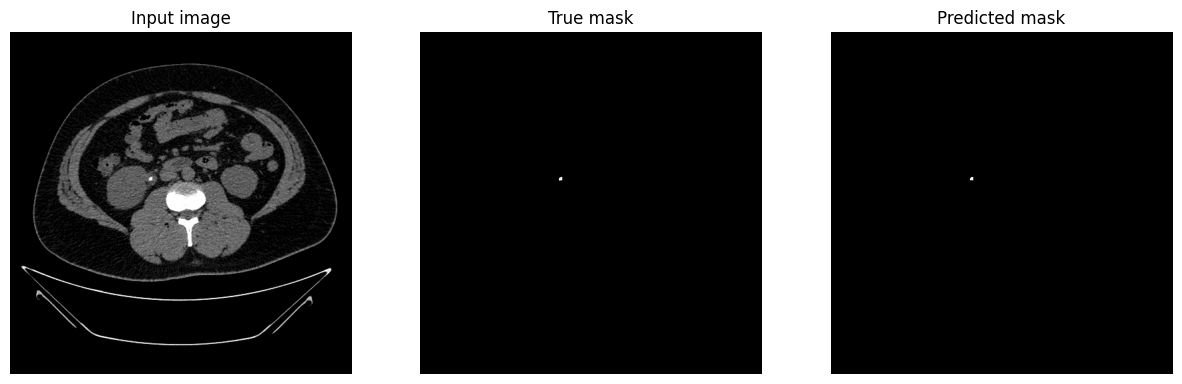

Accuracy: 0.9999885559082031
Jaccard: 0.875
Dice: 0.9333333333333333
Precision: 0.9545454545454546
Recall: 0.9130434782608695


In [28]:
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))